# Deep Q-Learning: State Representation Learning

This notebook demonstrates **how neural networks learn state representations** when using one-hot encoding in DQN.

## Goal

Show students that the **first hidden layer** of a DQN with one-hot inputs learns an **embedding** of each state. This embedding captures meaningful structure about the environment.

## Experiments

We'll compare two DQN architectures:
1. **DQN_OneHot (64D)**: Standard baseline with 64 hidden units
2. **DQN_OneHot_2D**: Extreme compression with only 2 hidden units (for visualization)

The 2D version will allow us to:
- Visualize the learned state embeddings in 2D space
- See which states the network clusters together
- Understand if the embedding reflects state values/importance

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import random
import time

from collections import deque
from tqdm import tqdm

## State Representation

FrozenLake provides states as integers (0-15 for 4x4 grid). We convert them to one-hot encoding for the neural network.

In [2]:
def state_to_onehot(state, num_states):
    """Convert integer state to one-hot encoding."""
    vec = np.zeros(num_states, dtype=np.float32)
    vec[state] = 1.0
    return vec

## Network Architectures

We'll train two variants of DQN with one-hot encoding:

In [3]:
class DQN_OneHot(nn.Module):
    """DQN with one-hot encoded states."""

    def __init__(self, state_dim, action_dim, hidden_dim=64):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.activation = nn.Tanh()
        self.fc2 = nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x


class DQN_OneHot_2D(nn.Module):
    """DQN with one-hot encoded states and 2D embedding layer.

    The first layer learns a 2D embedding for each state. With bias=True,
    each state's embedding is the corresponding weight column plus a learned
    offset, giving the network more flexibility to center the embeddings.
    """

    def __init__(self, state_dim, action_dim, hidden_dim=2):
        super().__init__()
        # With bias: embeddings = weight columns + learned offset
        self.fc1 = nn.Linear(state_dim, hidden_dim, bias=True)
        self.activation = nn.Tanh()
        self.fc2 = nn.Linear(hidden_dim, action_dim, bias=True)

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x

## Replay Buffer

Generic replay buffer that works with any state representation.

In [4]:
class ReplayBuffer:
    """Experience replay buffer that stores raw state integers."""

    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def add(self, transition):
        self.buffer.append(transition)

    def sample(self, batch_size, state_converter):
        """Sample batch and convert states using provided converter."""
        batch = random.sample(self.buffer, batch_size)
        s, a, r, s_, d = zip(*batch)

        # Convert states using the provided converter function
        s_converted = np.array([state_converter(state) for state in s])
        s_next_converted = np.array([state_converter(state) for state in s_])

        return (
            torch.tensor(s_converted, dtype=torch.float32),
            torch.tensor(a, dtype=torch.long),
            torch.tensor(r, dtype=torch.float32),
            torch.tensor(s_next_converted, dtype=torch.float32),
            torch.tensor(d, dtype=torch.float32),
        )

    def __len__(self):
        return len(self.buffer)

## Training Function

Generic training function that works with any network and state representation.

In [5]:
def train_dqn(
    env,
    policy_net,
    target_net,
    optimizer,
    loss_fn,
    device,
    buffer,
    state_converter,
    episodes,
    batch_size,
    epsilon,
    epsilon_decay,
    epsilon_min,
    gamma,
    target_update_freq,
    verbose=True,
):
    """Train DQN with replay buffer and target network enabled."""
    returns_per_episode = []

    iterator = tqdm(range(episodes)) if verbose else range(episodes)

    for ep in iterator:
        state, _ = env.reset()
        total_reward = 0
        done = False

        while not done:
            # Convert state and select action
            state_tensor = torch.tensor(
                state_converter(state), device=device, dtype=torch.float32
            )
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    q_vals = policy_net(state_tensor)
                    action = torch.argmax(q_vals).item()

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Store raw integer states in buffer
            buffer.add((state, action, reward, next_state, done))

            state = next_state
            total_reward += reward

            # Learn from replay buffer
            if len(buffer) >= batch_size:
                s, a, r, s_, d = [
                    x.to(device) for x in buffer.sample(batch_size, state_converter)
                ]

                q_values = policy_net(s).gather(1, a.unsqueeze(1)).squeeze()
                with torch.no_grad():
                    q_next = target_net(s_).max(1)[0]
                    q_target = r + gamma * q_next * (1 - d)

                loss = loss_fn(q_values, q_target)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # Update target network
        if (ep + 1) % target_update_freq == 0:
            target_net.load_state_dict(policy_net.state_dict())

        epsilon = max(epsilon * epsilon_decay, epsilon_min)
        returns_per_episode.append(total_reward)

    return returns_per_episode

## Hyperparameters

Same hyperparameters for all three approaches to ensure fair comparison.

In [6]:
# Environment
SIZE = 4
IS_SLIPPERY = False

# Training hyperparameters
episodes = 500
gamma = 0.99

epsilon = 0.1
epsilon_decay = 0.999
epsilon_min = 0.01

lr = 0.001
batch_size = 256
target_update_freq = 50
memory_capacity = 100_000

# Experiment settings
num_seeds = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## Run Experiments

Train both architectures with multiple seeds for statistical reliability.

In [7]:
# Store results for both architectures
results = {"onehot_64d": [], "onehot_2d": []}

# Store trained models (we'll need the 2D model for embedding analysis)
trained_models_2d = []

for seed in range(num_seeds):
    print(f"\n{'=' * 60}")
    print(f"SEED {seed + 1}/{num_seeds}")
    print(f"{'=' * 60}")

    # Set seeds for reproducibility
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    # ========== DQN_OneHot (64D Baseline) ==========
    print("\n[1/2] Training DQN_OneHot (64D baseline)...")
    env = gym.make(
        "FrozenLake-v1", desc=None, map_name=f"{SIZE}x{SIZE}", is_slippery=IS_SLIPPERY
    )

    policy_net = DQN_OneHot(
        state_dim=env.observation_space.n, action_dim=env.action_space.n, hidden_dim=64
    ).to(device)
    target_net = DQN_OneHot(
        state_dim=env.observation_space.n, action_dim=env.action_space.n, hidden_dim=64
    ).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()
    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    buffer = ReplayBuffer(memory_capacity)

    state_converter = lambda s: state_to_onehot(s, env.observation_space.n)
    returns = train_dqn(
        env,
        policy_net,
        target_net,
        optimizer,
        loss_fn,
        device,
        buffer,
        state_converter,
        episodes,
        batch_size,
        epsilon,
        epsilon_decay,
        epsilon_min,
        gamma,
        target_update_freq,
        verbose=(seed == 0),
    )
    results["onehot_64d"].append(returns)
    env.close()

    # Reset seeds
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    # ========== DQN_OneHot_2D (2D Embedding) ==========
    print("\n[2/2] Training DQN_OneHot_2D (2D embedding)...")
    env = gym.make(
        "FrozenLake-v1", desc=None, map_name=f"{SIZE}x{SIZE}", is_slippery=IS_SLIPPERY
    )

    policy_net = DQN_OneHot_2D(
        state_dim=env.observation_space.n, action_dim=env.action_space.n, hidden_dim=2
    ).to(device)
    target_net = DQN_OneHot_2D(
        state_dim=env.observation_space.n, action_dim=env.action_space.n, hidden_dim=2
    ).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()
    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    buffer = ReplayBuffer(memory_capacity)

    state_converter = lambda s: state_to_onehot(s, env.observation_space.n)
    returns = train_dqn(
        env,
        policy_net,
        target_net,
        optimizer,
        loss_fn,
        device,
        buffer,
        state_converter,
        episodes,
        batch_size,
        epsilon,
        epsilon_decay,
        epsilon_min,
        gamma,
        target_update_freq,
        verbose=(seed == 0),
    )
    results["onehot_2d"].append(returns)

    # Save trained model for embedding visualization
    trained_models_2d.append(policy_net.cpu().state_dict())

    env.close()

print("\n" + "=" * 60)
print("All experiments completed!")
print("=" * 60)


SEED 1/5

[1/2] Training DQN_OneHot (64D baseline)...


100%|██████████| 500/500 [00:11<00:00, 43.00it/s] 



[2/2] Training DQN_OneHot_2D (2D embedding)...


100%|██████████| 500/500 [00:15<00:00, 31.45it/s] 



SEED 2/5

[1/2] Training DQN_OneHot (64D baseline)...

[2/2] Training DQN_OneHot_2D (2D embedding)...

SEED 3/5

[1/2] Training DQN_OneHot (64D baseline)...

[2/2] Training DQN_OneHot_2D (2D embedding)...

SEED 4/5

[1/2] Training DQN_OneHot (64D baseline)...

[2/2] Training DQN_OneHot_2D (2D embedding)...

SEED 5/5

[1/2] Training DQN_OneHot (64D baseline)...

[2/2] Training DQN_OneHot_2D (2D embedding)...

All experiments completed!


## Performance Comparison

Let's compare how well the 2D embedding performs against the 64D baseline.

In [8]:
# Convert to numpy arrays for easier computation
onehot_64d_returns = np.array(results["onehot_64d"])  # Shape: (num_seeds, episodes)
onehot_2d_returns = np.array(results["onehot_2d"])

# Compute mean and std across seeds
onehot_64d_mean = onehot_64d_returns.mean(axis=0)
onehot_64d_std = onehot_64d_returns.std(axis=0)

onehot_2d_mean = onehot_2d_returns.mean(axis=0)
onehot_2d_std = onehot_2d_returns.std(axis=0)

# Compute rolling average (window=10) for smoother curves
window = 10


def rolling_avg(data, window):
    return np.convolve(data, np.ones(window) / window, mode="valid")


onehot_64d_rolling = rolling_avg(onehot_64d_mean, window)
onehot_2d_rolling = rolling_avg(onehot_2d_mean, window)

# Success rates
onehot_64d_success = (onehot_64d_returns > 0).astype(float)
onehot_2d_success = (onehot_2d_returns > 0).astype(float)

print(f"Results computed for {num_seeds} seeds over {episodes} episodes")

Results computed for 5 seeds over 500 episodes


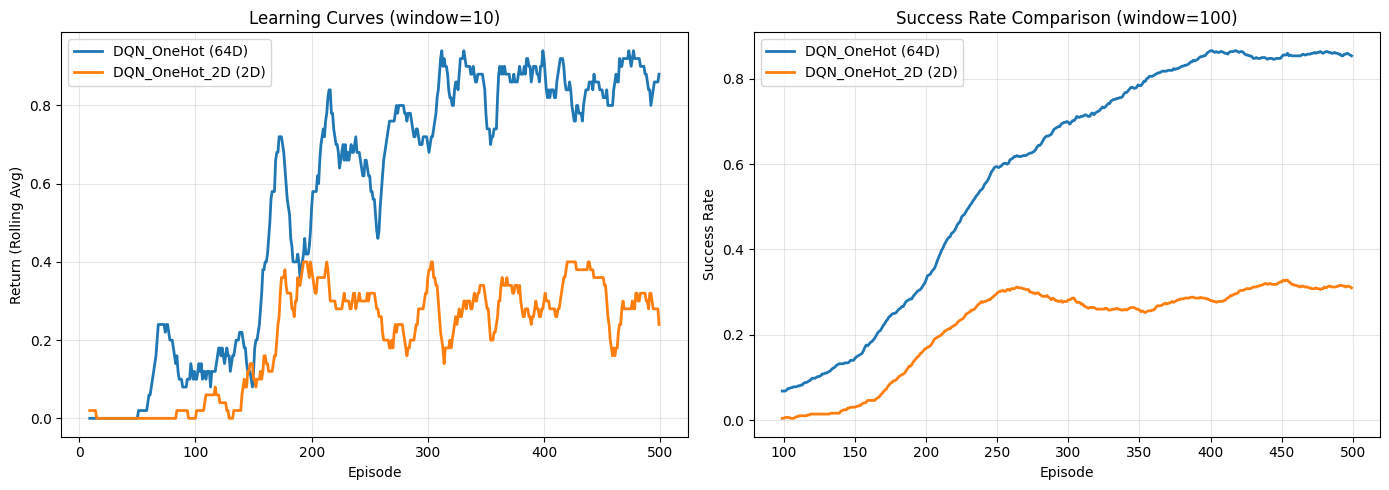

In [9]:
# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Learning curves (rolling average)
ax = axes[0]
episodes_rolling = np.arange(window - 1, episodes)
ax.plot(episodes_rolling, onehot_64d_rolling, label="DQN_OneHot (64D)", linewidth=2)
ax.plot(episodes_rolling, onehot_2d_rolling, label="DQN_OneHot_2D (2D)", linewidth=2)
ax.set_xlabel("Episode")
ax.set_ylabel("Return (Rolling Avg)")
ax.set_title(f"Learning Curves (window={window})")
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Success rates
ax = axes[1]
window_success = 100
onehot_64d_rolling_success = rolling_avg(
    onehot_64d_success.mean(axis=0), window_success
)
onehot_2d_rolling_success = rolling_avg(onehot_2d_success.mean(axis=0), window_success)

episodes_success = np.arange(window_success - 1, episodes)
ax.plot(
    episodes_success, onehot_64d_rolling_success, label="DQN_OneHot (64D)", linewidth=2
)
ax.plot(
    episodes_success, onehot_2d_rolling_success, label="DQN_OneHot_2D (2D)", linewidth=2
)
ax.set_xlabel("Episode")
ax.set_ylabel("Success Rate")
ax.set_title(f"Success Rate Comparison (window={window_success})")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [10]:
# Summary statistics
print("=" * 70)
print("PERFORMANCE COMPARISON")
print("=" * 70)

print("\n📊 DQN_OneHot (64D Baseline):")
print(
    f"  Final Success Rate: {onehot_64d_success[:, -100:].mean():.1%} ± {onehot_64d_success[:, -100:].std():.1%}"
)
print(
    f"  Final Return: {onehot_64d_returns[:, -100:].mean():.3f} ± {onehot_64d_returns[:, -100:].std():.3f}"
)

print("\n📊 DQN_OneHot_2D (2D Embedding):")
print(
    f"  Final Success Rate: {onehot_2d_success[:, -100:].mean():.1%} ± {onehot_2d_success[:, -100:].std():.1%}"
)
print(
    f"  Final Return: {onehot_2d_returns[:, -100:].mean():.3f} ± {onehot_2d_returns[:, -100:].std():.3f}"
)

# Compute performance difference
success_diff = onehot_2d_success[:, -100:].mean() - onehot_64d_success[:, -100:].mean()
print(f"\n📈 Difference (2D - 64D): {success_diff:+.1%}")

if abs(success_diff) < 0.05:
    print("   → 2D model is competitive despite 32x fewer parameters!")
elif success_diff > 0:
    print("   → 2D model surprisingly outperforms!")
else:
    print("   → 2D model trades some performance for interpretability")

print("\n" + "=" * 70)

PERFORMANCE COMPARISON

📊 DQN_OneHot (64D Baseline):
  Final Success Rate: 85.4% ± 35.3%
  Final Return: 0.854 ± 0.353

📊 DQN_OneHot_2D (2D Embedding):
  Final Success Rate: 31.0% ± 46.2%
  Final Return: 0.310 ± 0.462

📈 Difference (2D - 64D): -54.4%
   → 2D model trades some performance for interpretability



## Embedding Analysis: Understanding the Learned Representations

Now comes the interesting part! Let's examine what the 2D model learned.

The first layer weights and bias form an **embedding** where each state maps to a 2D point. For a one-hot encoded state, the embedding is simply the corresponding weight column plus the bias offset.

**Key Questions:**
1. Do nearby states in the grid cluster together in embedding space?
2. Do special states (start, goal, holes) form distinct patterns?
3. Does the embedding reflect state values/importance?

In [11]:
# Extract embeddings from the first trained model (seed 0)
# We'll use seed 0 for visualization, but patterns are consistent across seeds

# Load the trained model
model_2d = DQN_OneHot_2D(state_dim=16, action_dim=4, hidden_dim=2)
model_2d.load_state_dict(trained_models_2d[0])
model_2d.eval()

# Extract first layer weights and bias (the embedding matrix)
# Shape: (hidden_dim=2, state_dim=16)
# Each column i contains the 2D weight vector for state i
embedding_matrix = model_2d.fc1.weight.data.numpy()  # Shape: (2, 16)
bias_vector = model_2d.fc1.bias.data.numpy()  # Shape: (2,)

print(f"Embedding matrix shape: {embedding_matrix.shape}")
print(f"Bias vector shape: {bias_vector.shape}")
print(
    f"This means: {embedding_matrix.shape[1]} states × {embedding_matrix.shape[0]} dimensions + bias offset"
)

# Transpose to get (16 states, 2 dimensions) and add bias
# For one-hot input, embedding for state i = weight[:, i] + bias
embeddings_2d = embedding_matrix.T + bias_vector  # Shape: (16, 2)

print(f"\nFinal embeddings shape: {embeddings_2d.shape}")

# Create state grid information for annotation
grid_size = SIZE
state_coords = []
for state in range(16):
    row = state // grid_size
    col = state % grid_size
    state_coords.append((row, col))

# Define special states for FrozenLake 4x4
# Map layout (from Gymnasium FrozenLake-v1):
# SFFF
# FHFH
# FFFH
# HFFG
start_state = 0
goal_state = 15
hole_states = [5, 7, 11, 12]  # Holes in the 4x4 grid

print(f"\nSpecial states:")
print(f"  Start: {start_state} (0,0)")
print(f"  Goal: {goal_state} (3,3)")
print(f"  Holes: {hole_states}")

Embedding matrix shape: (2, 16)
Bias vector shape: (2,)
This means: 16 states × 2 dimensions + bias offset

Final embeddings shape: (16, 2)

Special states:
  Start: 0 (0,0)
  Goal: 15 (3,3)
  Holes: [5, 7, 11, 12]


### Visualization 1: 2D Scatter Plot with State Labels

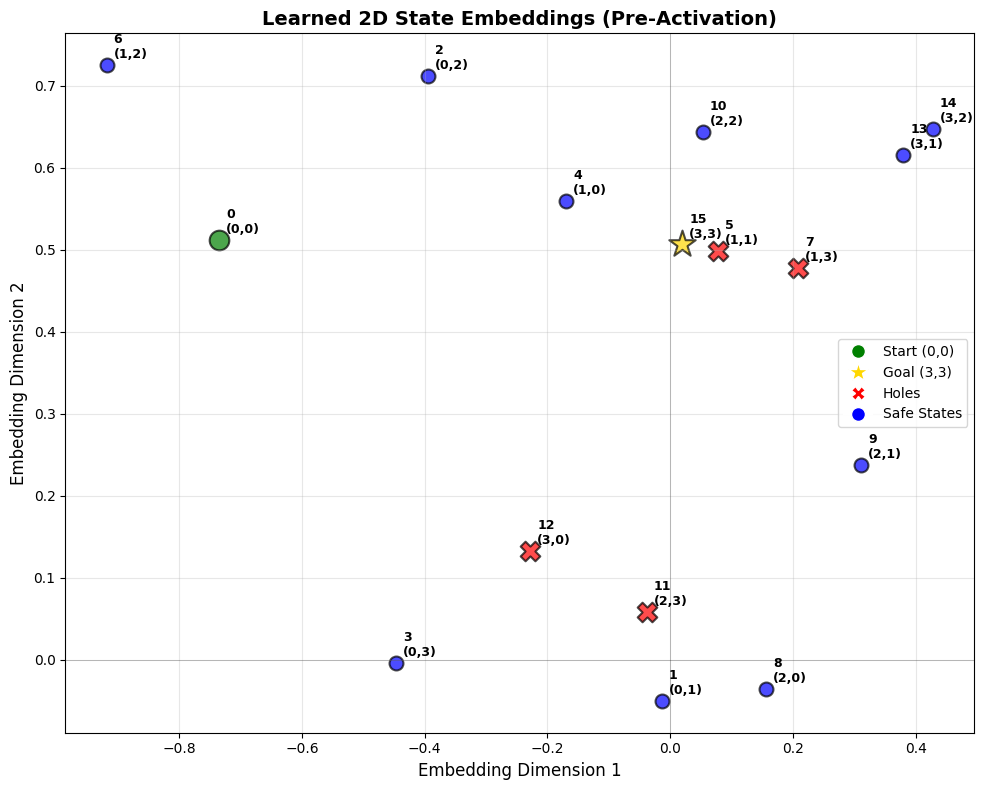

In [12]:
plt.figure(figsize=(10, 8))

# Plot all states
for state in range(16):
    x, y = embeddings_2d[state]
    row, col = state_coords[state]

    # Color code by state type
    if state == start_state:
        color = "green"
        marker = "o"
        size = 200
        label = "Start"
    elif state == goal_state:
        color = "gold"
        marker = "*"
        size = 400
        label = "Goal"
    elif state in hole_states:
        color = "red"
        marker = "X"
        size = 200
        label = "Hole"
    else:
        color = "blue"
        marker = "o"
        size = 100
        label = "Safe"

    # Plot point
    plt.scatter(
        x,
        y,
        c=color,
        marker=marker,
        s=size,
        alpha=0.7,
        edgecolors="black",
        linewidth=1.5,
    )

    # Annotate with state number and grid position
    plt.annotate(
        f"{state}\n({row},{col})",
        (x, y),
        xytext=(5, 5),
        textcoords="offset points",
        fontsize=9,
        fontweight="bold",
    )

# Create custom legend
from matplotlib.lines import Line2D

legend_elements = [
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor="green",
        markersize=10,
        label="Start (0,0)",
    ),
    Line2D(
        [0],
        [0],
        marker="*",
        color="w",
        markerfacecolor="gold",
        markersize=15,
        label="Goal (3,3)",
    ),
    Line2D(
        [0],
        [0],
        marker="X",
        color="w",
        markerfacecolor="red",
        markersize=10,
        label="Holes",
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor="blue",
        markersize=10,
        label="Safe States",
    ),
]
plt.legend(handles=legend_elements, loc="best", fontsize=10)

plt.xlabel("Embedding Dimension 1", fontsize=12)
plt.ylabel("Embedding Dimension 2", fontsize=12)
plt.title(
    "Learned 2D State Embeddings (Pre-Activation)", fontsize=14, fontweight="bold"
)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color="k", linewidth=0.5, alpha=0.3)
plt.axvline(x=0, color="k", linewidth=0.5, alpha=0.3)
plt.tight_layout()
plt.show()

### Visualization 2: Embedding Weight Heatmap

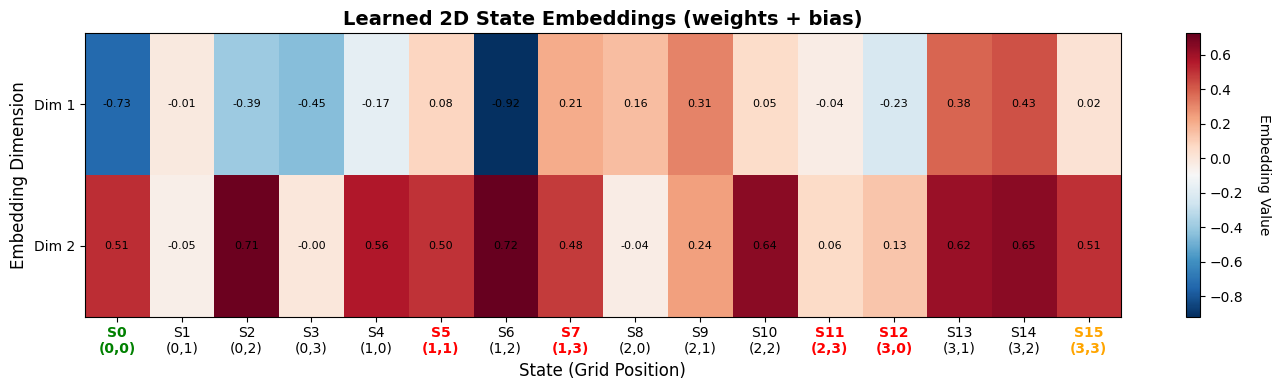


Interpretation:
- Each column shows how a state is represented in 2D space
- Embeddings = weight columns + bias offset
- The network learned these to maximize Q-value prediction accuracy


In [13]:
fig, ax = plt.subplots(figsize=(14, 4))

# Plot heatmap of embeddings (16 states × 2 dimensions)
im = ax.imshow(embeddings_2d.T, cmap="RdBu_r", aspect="auto")

# Set ticks and labels
ax.set_xticks(np.arange(16))
ax.set_yticks([0, 1])
ax.set_xticklabels([f"S{i}\n({i // 4},{i % 4})" for i in range(16)])
ax.set_yticklabels(["Dim 1", "Dim 2"])

# Add state type annotations on x-axis
for state in range(16):
    if state == start_state:
        ax.get_xticklabels()[state].set_color("green")
        ax.get_xticklabels()[state].set_weight("bold")
    elif state == goal_state:
        ax.get_xticklabels()[state].set_color("orange")
        ax.get_xticklabels()[state].set_weight("bold")
    elif state in hole_states:
        ax.get_xticklabels()[state].set_color("red")
        ax.get_xticklabels()[state].set_weight("bold")

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Embedding Value", rotation=270, labelpad=20)

# Add cell values
for i in range(2):
    for j in range(16):
        text = ax.text(
            j,
            i,
            f"{embeddings_2d[j, i]:.2f}",
            ha="center",
            va="center",
            color="black",
            fontsize=8,
        )

ax.set_xlabel("State (Grid Position)", fontsize=12)
ax.set_ylabel("Embedding Dimension", fontsize=12)
ax.set_title(
    "Learned 2D State Embeddings (weights + bias)",
    fontsize=14,
    fontweight="bold",
)

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- Each column shows how a state is represented in 2D space")
print("- Embeddings = weight columns + bias offset")
print("- The network learned these to maximize Q-value prediction accuracy")

### Visualization 3: Embeddings Colored by State Value

In [14]:
# Compute state values V(s) = max_a Q(s, a) for each state
state_values = []

with torch.no_grad():
    for state in range(16):
        # Convert state to one-hot
        state_onehot = torch.tensor(state_to_onehot(state, 16), dtype=torch.float32)
        # Get Q-values for all actions
        q_values = model_2d(state_onehot)
        # State value is the maximum Q-value
        v = q_values.max().item()
        state_values.append(v)

state_values = np.array(state_values)

print(f"State values (V(s) = max_a Q(s,a)):")
for state in range(16):
    row, col = state_coords[state]
    state_type = (
        "START"
        if state == start_state
        else "GOAL"
        if state == goal_state
        else "HOLE"
        if state in hole_states
        else "SAFE"
    )
    print(
        f"  State {state:2d} ({row},{col}) [{state_type:5s}]: V = {state_values[state]:6.3f}"
    )

State values (V(s) = max_a Q(s,a)):
  State  0 (0,0) [START]: V =  0.863
  State  1 (0,1) [SAFE ]: V =  0.887
  State  2 (0,2) [SAFE ]: V =  1.118
  State  3 (0,3) [SAFE ]: V =  0.696
  State  4 (1,0) [SAFE ]: V =  0.947
  State  5 (1,1) [HOLE ]: V =  0.913
  State  6 (1,2) [SAFE ]: V =  1.116
  State  7 (1,3) [HOLE ]: V =  0.978
  State  8 (2,0) [SAFE ]: V =  0.979
  State  9 (2,1) [SAFE ]: V =  1.056
  State 10 (2,2) [SAFE ]: V =  1.061
  State 11 (2,3) [HOLE ]: V =  0.872
  State 12 (3,0) [HOLE ]: V =  0.783
  State 13 (3,1) [SAFE ]: V =  1.073
  State 14 (3,2) [SAFE ]: V =  1.099
  State 15 (3,3) [GOAL ]: V =  0.886


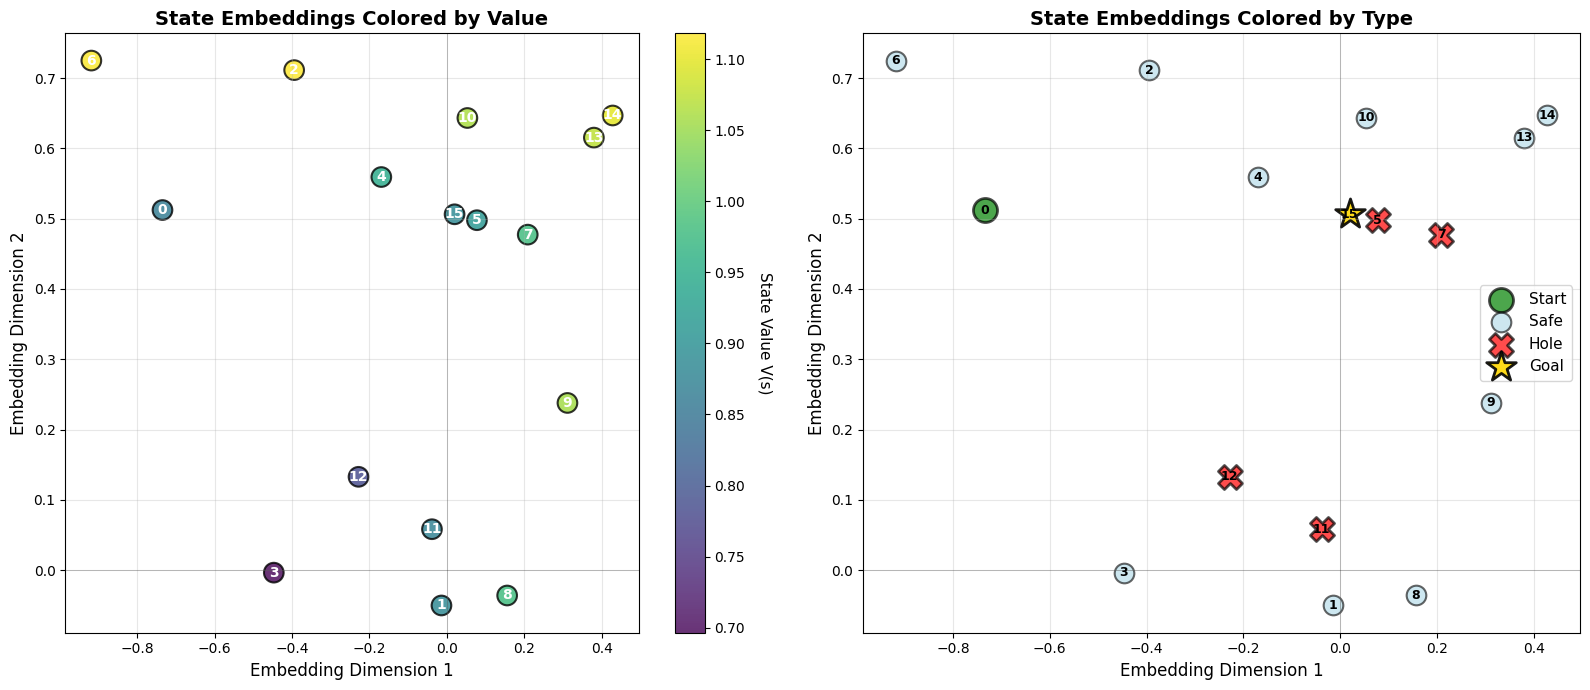


Observations:
- Do high-value states cluster together in embedding space?
- Do holes cluster separately from safe states?
- Does the embedding capture the importance/value of states?


In [15]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Plot 1: Colored by state value
ax = axes[0]
scatter = ax.scatter(
    embeddings_2d[:, 0],
    embeddings_2d[:, 1],
    c=state_values,
    cmap="viridis",
    s=200,
    edgecolors="black",
    linewidth=1.5,
    alpha=0.8,
)

# Annotate states
for state in range(16):
    x, y = embeddings_2d[state]
    row, col = state_coords[state]
    ax.annotate(
        f"{state}",
        (x, y),
        ha="center",
        va="center",
        fontsize=10,
        fontweight="bold",
        color="white",
    )

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label("State Value V(s)", rotation=270, labelpad=20, fontsize=11)

ax.set_xlabel("Embedding Dimension 1", fontsize=12)
ax.set_ylabel("Embedding Dimension 2", fontsize=12)
ax.set_title("State Embeddings Colored by Value", fontsize=14, fontweight="bold")
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color="k", linewidth=0.5, alpha=0.3)
ax.axvline(x=0, color="k", linewidth=0.5, alpha=0.3)

# Plot 2: Colored by state type with larger markers
ax = axes[1]
for state in range(16):
    x, y = embeddings_2d[state]

    if state == start_state:
        ax.scatter(
            x,
            y,
            c="green",
            marker="o",
            s=300,
            alpha=0.7,
            edgecolors="black",
            linewidth=2,
            label="Start",
        )
    elif state == goal_state:
        ax.scatter(
            x,
            y,
            c="gold",
            marker="*",
            s=500,
            alpha=0.9,
            edgecolors="black",
            linewidth=2,
            label="Goal",
        )
    elif state in hole_states:
        ax.scatter(
            x,
            y,
            c="red",
            marker="X",
            s=300,
            alpha=0.7,
            edgecolors="black",
            linewidth=2,
            label="Hole",
        )
    else:
        ax.scatter(
            x,
            y,
            c="lightblue",
            marker="o",
            s=200,
            alpha=0.6,
            edgecolors="black",
            linewidth=1.5,
            label="Safe",
        )

    # Add state number
    ax.annotate(
        f"{state}", (x, y), ha="center", va="center", fontsize=9, fontweight="bold"
    )

# Remove duplicate labels
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc="best", fontsize=11)

ax.set_xlabel("Embedding Dimension 1", fontsize=12)
ax.set_ylabel("Embedding Dimension 2", fontsize=12)
ax.set_title("State Embeddings Colored by Type", fontsize=14, fontweight="bold")
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color="k", linewidth=0.5, alpha=0.3)
ax.axvline(x=0, color="k", linewidth=0.5, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nObservations:")
print("- Do high-value states cluster together in embedding space?")
print("- Do holes cluster separately from safe states?")
print("- Does the embedding capture the importance/value of states?")